In [64]:
import numpy as np
from numpy import radians
import matplotlib.pyplot as plt
TF = 60

### Criação do sistema

In [65]:
# Creates vehicle and set values
from pyaat.aircraft import Aircraft
minhaAeronave = Aircraft(mass=45e3, Ixx=0.554e6, Iyy=2.53e6,
                         Izz =3.01e6, Izx=0.106e6, Cbarw =3.666,
                         bw=28.42, Sw=95.0)


# Aerodynamic coeficients
minhaAeronave.coef0 = [0.0252, 0.0, 0.382, 0.0, 0.0622, 0.0]
minhaAeronave.coefALPHA = [0.2010, 0.0, 6.29, 0.0, -3.63, 0.0]
minhaAeronave.coefBETA = [0.0, 0.785, 0.0, -0.121, 0.0, 0.174]
minhaAeronave.coefP = [0.0, -0.0794, 0.0, -0.522, 0.0, -0.0587]
minhaAeronave.coefQ = [0.281, 0.0, 14.6, 0.0, -45.5, 0.0]
minhaAeronave.coefR = [0.0, 0.572, 0.0, 0.254, 0.0, -0.277]

minhaAeronave.CLmax = 2.4
minhaAeronave.qmax = 23052.05 # considering 700km/h at sea level
minhaAeronave.Vinf = 200

# Environment

minhaAeronave.set_control_surface('Profundor', [0.0126, 0.0, 0.3891, 0.0, -1.5980, 0.0],(radians(-30), radians(30)))
minhaAeronave.set_control_surface('Aileron', [0.0, 0.0094, 0.0, -0.1784, 0.0, 0.0080],(radians(-20), radians(30)))
minhaAeronave.set_control_surface('Leme', [0.0, -0.3030, 0.0, -0.0464, 0.0, -0.1594],(radians(-40), radians(40)))

from pyaat.atmosphere import atmosISA
minhaAtmosfera = atmosISA()

from pyaat.gravity import Earth_NewtonGravity
minhaGravidade = Earth_NewtonGravity()

from pyaat.propulsion import JetModel
MotorEsquerdo = JetModel('Motor esquerdo', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorEsquerdo.position = np.array([0, -5, 1.42])
MotorEsquerdo.attitude = np.array([0., radians(3.), 0.])

MotorDireito = JetModel('Motor direito', Fmaxi = 35e3, nrho = 0.775, rhoi = 0.41271,
                         Vi = 200.0, nv = 0)
MotorDireito.position = np.array([0, 5.0, 1.42])
MotorDireito.attitude = np.array([0., radians(3.), 0.])

minhaPropulsao = [MotorEsquerdo, MotorDireito]

from pyaat.system import system
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade)

### Balanço

In [66]:
Xe, Ue = meuSistema.trimmer(condition = 'cruize', zo = -10000, u =224.6)

In [67]:
Xe_curva, Ue_curva = meuSistema.trimmer(condition = 'turn', zo = -10000, u = 224.6,
                                        psid = np.radians(6.), beta = np.radians(0))

### Perturbações

In [68]:
#from wind import gust
#rajada = gust(MaxSpeed = 5, xo = 500, xf = 1000, yo = -1000, yf = 1000)
meusVentos = []

from pyaat.pyaatcontrol import doublet
pert_leme = doublet('Leme', amplitude = np.radians(2.), t_init =  20, T = 4)
pert_ail = doublet('Aileron', amplitude = np.radians(2.), t_init =  40, T = 4)
openloopcontrols = [pert_leme, pert_ail]

### Inclui Sensores

In [69]:
from pyaat.pyaatcontrol import actuator
act_leme = actuator(name = 'ss leme', command = 'Leme', tau = 0.2)
act_aileron = actuator(name = 'ss aileron', command = 'Aileron', tau = 0.2)
actuatorsAndFilters = [act_leme, act_aileron]

In [70]:
meuSistema = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters)

In [71]:
solution1, controls1 = meuSistema.simulate(Xe_curva, Ue_curva, T0 = 0.0, TF = TF,
                                            control = openloopcontrols)
tempo1  = meuSistema.time

In [72]:
print(meuSistema.controlsNames)

['Profundor', 'Aileron', 'Leme', 'Motor esquerdo thrust', 'Motor esquerdo psip', 'Motor esquerdo thetap', 'Motor direito thrust', 'Motor direito psip', 'Motor direito thetap']


In [73]:
print(meuSistema.statesNames)

['xo', 'yo', 'zo', 'u', 'v', 'w', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'ss leme', 'ss aileron']


### Linearização

In [74]:
A, B = meuSistema.Linearize(Xe, Ue)

### Análise qualidade de voo

In [75]:
from numpy import sqrt
def fingOmegaZeta(real, img):
    omega = np.sqrt((-real)**2 + img**2)
    zeta = -real/(np.sqrt((-real)**2+img**2))
    
    if (img==0):
        omega = 1/real
        zeta = "Non-oscilatory"
        
    return omega, zeta

In [76]:
from pyaat.flightmechanics import spiralQuality, dutchRollQuality, rollQuality
from pyaat.flightmechanics import lateroMatrix, dutchRollMatrix, spiralMatrix, rollMatrix, longMatrix
from numpy.linalg import eig

In [77]:
Ald, Bld = lateroMatrix(A, B)
wt, vt = eig(A)
wt

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -9.11115873e-01+2.23686691j,
       -9.11115873e-01-2.23686691j, -1.81559552e-03+0.06695671j,
       -1.81559552e-03-0.06695671j, -1.01655344e-03+0.j        ,
       -3.80875970e+00+0.j        , -1.21672218e-01+1.33476112j,
       -1.21672218e-01-1.33476112j,  4.99694890e-03+0.j        ])

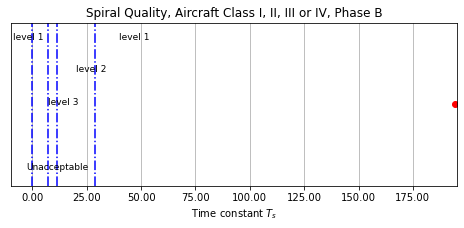

In [78]:
T, z = fingOmegaZeta(5.14595852e-03, 0)
spiralQuality(T, aircraft = 'III', phase = 'B')

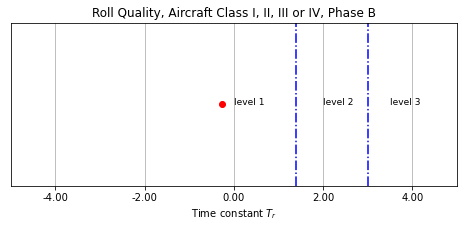

In [79]:
T, z = fingOmegaZeta(-3.80856704, 0)
rollQuality(T, aircraft = 'III', phase = 'B')

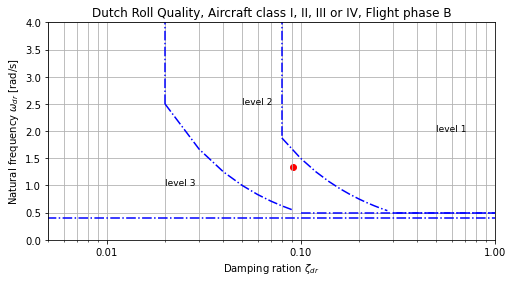

In [80]:
w, z = fingOmegaZeta(-1.22001447e-01, 1.33396416)
dutchRollQuality(w, z, aircraft = 'III', phase = 'B')

### Inclui controladores

In [81]:
from pyaat.pyaatcontrol import P, loop, HighPassFilter

P1 = P(name = 'P1', gain = 0.5)
loop1 = loop(name = 'L1', Xmeasure = 'p', Xreference = 'p', command = 'Aileron')
loop1.loopControls = [P1]

washout = HighPassFilter(name = 'washout', tau = 1)
P2 = P(name = 'P2', gain = 0.5)
loop2 = loop(name = 'L2', Xmeasure= 'r', Xreference = 'r',  command ='Leme')
loop2.loopControls = [washout, P2]
closedloopcontrols = [loop1, loop2]

meuSistema2 = system(atmosphere = minhaAtmosfera,
                    propulsion = minhaPropulsao,
                    aircraft = minhaAeronave,
                    gravity = minhaGravidade,
                    wind = meusVentos,
                    extraDynamics = actuatorsAndFilters,
                    control = closedloopcontrols)

In [82]:
print(meuSistema2.statesNames)

['xo', 'yo', 'zo', 'u', 'v', 'w', 'phi', 'theta', 'psi', 'p', 'q', 'r', 'ss leme', 'ss aileron', 'washout']


In [83]:
solution2, controls2 = meuSistema2.simulate(Xe_curva, Ue_curva, T0 = 0.0, TF = TF,
                                            control = openloopcontrols)
tempo2  = meuSistema2.time

### Linearização

In [84]:
Xea = np.append(Xe,[Ue[2], Ue[1], Xe[11]])
Aa, Ba = meuSistema2.FullLinearize(Xea, Ue)

In [85]:
wta, vta = eig(Aa)
wta

array([ 0.00000000e+00+0.j        ,  0.00000000e+00+0.j        ,
        0.00000000e+00+0.j        , -9.11115873e-01+2.23686691j,
       -9.11115873e-01-2.23686691j, -4.38882410e+00+4.76601676j,
       -4.38882410e+00-4.76601676j, -1.81559552e-03+0.06695671j,
       -1.81559552e-03-0.06695671j, -3.62819245e+00+0.j        ,
       -1.01655344e-03+0.j        , -1.98932941e+00+0.j        ,
       -3.27262144e-01+1.03297126j, -3.27262144e-01-1.03297126j,
        2.58716549e-03+0.j        ])

In [86]:
Al, Bl = longMatrix(A, B)
wt, vt = eig(Al)
wt

array([-0.91111587+2.23686691j, -0.91111587-2.23686691j,
       -0.0018156 +0.06695671j, -0.0018156 -0.06695671j,
       -0.00101655+0.j        ])

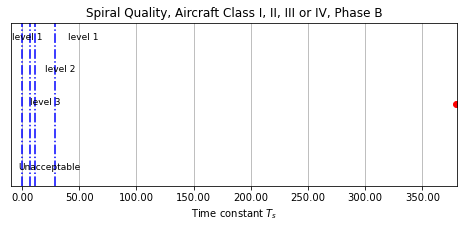

In [87]:
T, z = fingOmegaZeta(2.63585732e-03, 0)
spiralQuality(T, aircraft = 'III', phase = 'B')
#plt.savefig('spiral_CL.pdf', dpi = 400, bbox_inches='tight')

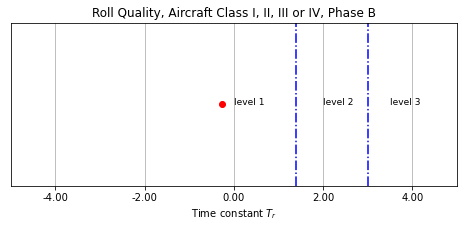

In [88]:
T, z = fingOmegaZeta(-3.6279, 0)
rollQuality(T, aircraft = 'III', phase = 'B')
#plt.savefig('roll_CL.pdf', dpi = 400, bbox_inches='tight')

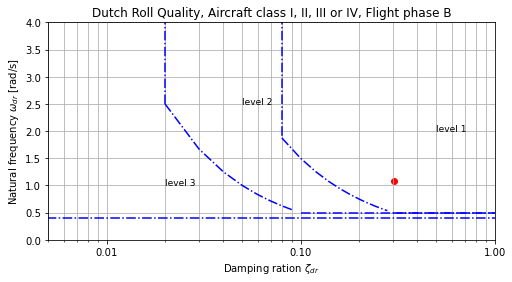

In [89]:
w, z = fingOmegaZeta(-3.26946211e-01, 1.03254272)
dutchRollQuality(w, z, aircraft = 'III', phase = 'B')
#plt.savefig('dutch_roll_CL.pdf', dpi = 400, bbox_inches='tight')

### resultados Simulações

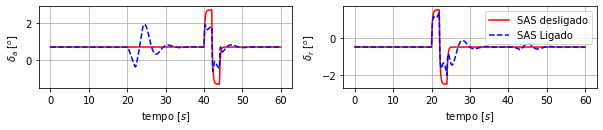

In [90]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1, ncols=2, sharex=True, figsize=(10,1.5))
ax[0].plot(tempo1, np.around(np.degrees(solution1[:,13]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0].plot(tempo2, np.around(np.degrees(solution2[:,13]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0].set_ylabel(r'$\delta_a$ $[^o]$')
ax[0].set_xlabel(r'tempo $[s]$')
ax[0].grid()

ax[1].plot(tempo1, np.around(np.degrees(solution1[:,12]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1].plot(tempo2, np.around(np.degrees(solution2[:,12]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1].set_ylabel(r'$\delta_r$ $[^o]$')
ax[1].set_xlabel(r'tempo $[s]$')
ax[1].legend(loc = 'upper right')
ax[1].grid()
#plt.savefig('SAS_latero_controles.pdf', dpi = 400, bbox_inches='tight')

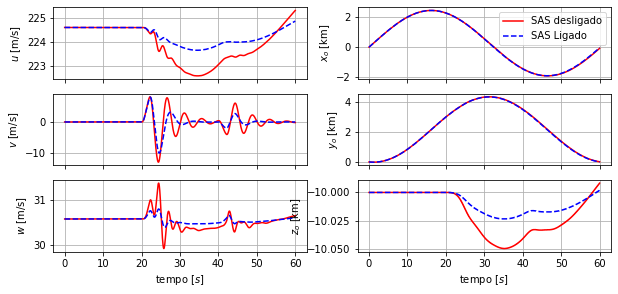

In [91]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,4.5))
ax[0,0].plot(tempo1, np.around((solution1[:,3]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0,0].plot(tempo2, np.around((solution2[:,3]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r'$u$ [m/s]')
ax[0,0].grid()

ax[1,0].plot(tempo1, np.around((solution1[:,4]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1,0].plot(tempo2, np.around((solution2[:,4]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r'$v$ [m/s]')
ax[1,0].grid()

ax[2,0].plot(tempo1, np.around((solution1[:,5]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[2,0].plot(tempo2, np.around((solution2[:,5]), decimals=4),label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[2,0].set_ylabel(r'$w$ [m/s]')
ax[2,0].set_xlabel(r'tempo $[s]$')
ax[2,0].grid()

ax[0, 1].plot(tempo1, np.around((solution1[:,0]/1000), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0, 1].plot(tempo2, np.around((solution2[:,0]/1000), decimals=4),label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r'$x_o$ [km]')
ax[0, 1].legend(loc = 'upper right')
ax[0, 1].grid()

ax[1, 1].plot(tempo1, np.around((solution1[:,1]/1000), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1, 1].plot(tempo2, np.around((solution2[:,1]/1000), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1, 1].set_ylabel(r'$y_o$ [km]')
ax[1, 1].grid()

ax[2, 1].plot(tempo1, np.around((solution1[:,2]/1000), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[2, 1].plot(tempo2, np.around((solution2[:,2]/1000), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[2, 1].set_ylabel(r'$z_o$ [km]')
ax[2, 1].set_xlabel(r'tempo $[s]$')
ax[2, 1].grid()
#plt.savefig('sas_latero_linear.pdf', dpi = 400, bbox_inches='tight')

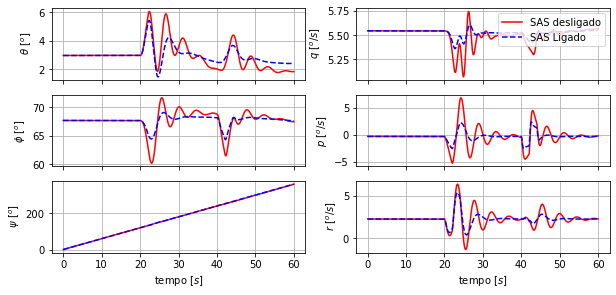

In [92]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(10,4.5))
ax[1,0].plot(tempo1, np.around(np.degrees(solution1[:,6]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1,0].plot(tempo2, np.around(np.degrees(solution2[:,6]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1,0].set_ylabel(r'$\phi~ [^o]$')
ax[1,0].grid()

ax[0,0].plot(tempo1, np.around(np.degrees(solution1[:,7]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0,0].plot(tempo2, np.around(np.degrees(solution2[:,7]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0,0].set_ylabel(r' $\theta~ [^o]$')
ax[0,0].grid()

ax[2,0].plot(tempo1, np.around(np.degrees(solution1[:,8]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[2,0].plot(tempo2, np.around(np.degrees(solution2[:,8]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[2,0].set_ylabel(r' $\psi~ [^o]$')
ax[2,0].set_xlabel(r'tempo $[s]$')
ax[2,0].grid()

ax[1, 1].plot(tempo1, np.around(np.degrees(solution1[:,9]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[1, 1].plot(tempo2, np.around(np.degrees(solution2[:,9]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[1, 1].set_ylabel(r'$p~ [^o/s]$')
ax[1, 1].grid()

ax[0, 1].plot(tempo1, np.around(np.degrees(solution1[:,10]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[0, 1].plot(tempo2, np.around(np.degrees(solution2[:,10]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[0, 1].set_ylabel(r' $q~ [^o/s]$')
ax[0, 1].legend(loc = 'upper right')

ax[0, 1].grid()

ax[2, 1].plot(tempo1, np.around(np.degrees(solution1[:,11]), decimals=4), color = 'r', linestyle = '-', label = r'SAS desligado')
ax[2, 1].plot(tempo2, np.around(np.degrees(solution2[:,11]), decimals=4), label = r'SAS Ligado', color = 'b', linestyle = '--')
ax[2, 1].set_ylabel(r' $r~ [^o/s]$')
ax[2, 1].set_xlabel(r'tempo $[s]$')
ax[2, 1].grid()
#plt.savefig('sas_latero_angular.pdf', dpi = 400, bbox_inches='tight')

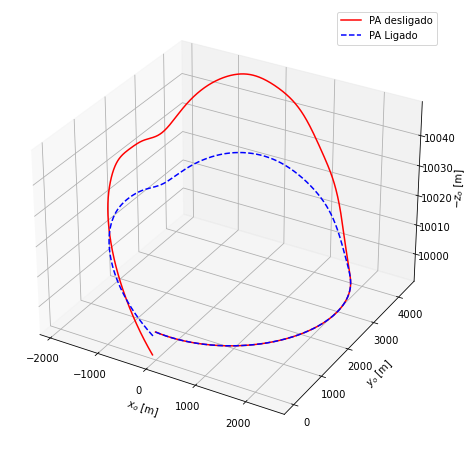

In [93]:
fig = plt.figure(figsize = [8,8])
ax = fig.add_subplot(111, projection='3d')
ax.plot3D(np.around(solution1[:,0], decimals=4),
          np.around(solution1[:,1], decimals=4),
          np.around(-solution1[:,2], decimals=4),
          color = 'r', linestyle = '-', label = r'PA desligado')

ax.plot3D(np.around(solution2[:,0], decimals=4),
          np.around(solution2[:,1], decimals=4),
          np.around(-solution2[:,2], decimals=4),
          label = r'PA Ligado', color = 'b', linestyle = '--')
ax.set_xlabel('$x_o$ [m]')
ax.set_ylabel('$y_o$ [m]')
ax.set_zlabel('$-z_o$ [m]')
ax.legend()
#plt.savefig('3d_SAS_latero.pdf', dpi = 400, bbox_inches='tight')